# Predict
Similar to training, prediction can be done via three interfaces:
- via python, `das.predict.predict`
- via the command line, `das predict`, with audio data from a wav file.
- the GUI - see the [GUI tutorial](/tutorials_gui/predict)

Prediction will:

- load the audio data and the network
- run inference to produce confidence scores (`class_probabilties`)
- post-process the confidence score to extract the times of events and label segments.


## Prediction using python

In [1]:
import numpy as np
from pprint import pprint
import scipy.io.wavfile
import das.predict
help(das.predict.predict)

Help on function predict in module das.predict:

predict(x: numpy.ndarray, model_save_name: str = None, verbose: int = 1, batch_size: int = None, model: keras.engine.training.Model = None, params: dict = None, event_thres: float = 0.5, event_dist: float = 0.01, event_dist_min: float = 0, event_dist_max: float = None, segment_thres: float = 0.5, segment_use_optimized: bool = True, segment_minlen: float = None, segment_fillgap: float = None, pad: bool = True, prepend_data_padding: bool = True)
    [summary]
    
    Usage:
    Calling predict with the path to the model will load the model and the
    associated params and run inference:
    `das.predict.predict(x=data, model_save_name='tata')`
    
    To re-use the same model with multiple recordings, load the modal and params
    once and pass them to `predict`
    ```my_model, my_params = das.utils.load_model_and_params(model_save_name)
    for data in data_list:
        das.predict.predict(x=data, model=my_model, params=my_params)
  

In [2]:
%%time
samplerate, x = scipy.io.wavfile.read('dat/dmel_song_rt.wav')
print(f"DAS requires [T, channels], but single-channel wave files are loaded with shape [T,] (data shape is {x.shape}).")
x = np.atleast_2d(x).T
events, segments, class_probabilities, class_names = das.predict.predict(x, 
                                                           model_save_name='models/dmel_single_rt/20200430_201821',
                                                           verbose=2,
                                                           segment_minlen=0.02,
                                                           segment_fillgap=0.02)

DAS requires [T, channels], but single-channel wave files are loaded with shape [T,] (data shape is (35000,)).


/Users/clemens10/miniconda3/lib/python3.9/site-packages/keras/layers/core.py:1043: UserWarning: dss.tcn.tcn is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '
2022-07-25 13:02:25.335763: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-25 13:02:25.918851: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


20/20 - 2s
CPU times: user 5.92 s, sys: 895 ms, total: 6.82 s
Wall time: 2.62 s


### Outputs of `predict`
- `class_probabilties`: `[T, nb_classes]` including noise.
- `segments`: Labelled segments
    - `samplerate_Hz`: 
    - `names`: names of all segment types
    - `index`: indices of all segments types into class_probabiltiies
    - `probabilities = class_probabilites[:, index]`
    - `sequence`: sequence of segment names (one entry per detected segment). Excludes noise
    - `samples`: labelled sample trace (label of the sequence occupying each sample)
    - `onsets_seconds`, `offsets_seconds`, `durations_seconds`: Onsets, offsets, and duration of individual segmeents
- `events`: Detected events
    - `samplerate_Hz`: 
    - `index`: indices of all events types into class_probabiltiies
    - `names`: names of all event types
    - `probabilities`: probabilities (confidence scores) for detected events. Value of `class_probabilities` for the detected event index at each event time.
    - `seconds`: times (seconds) of detected events
    - `sequence`: sequence of event names (one per detected event).

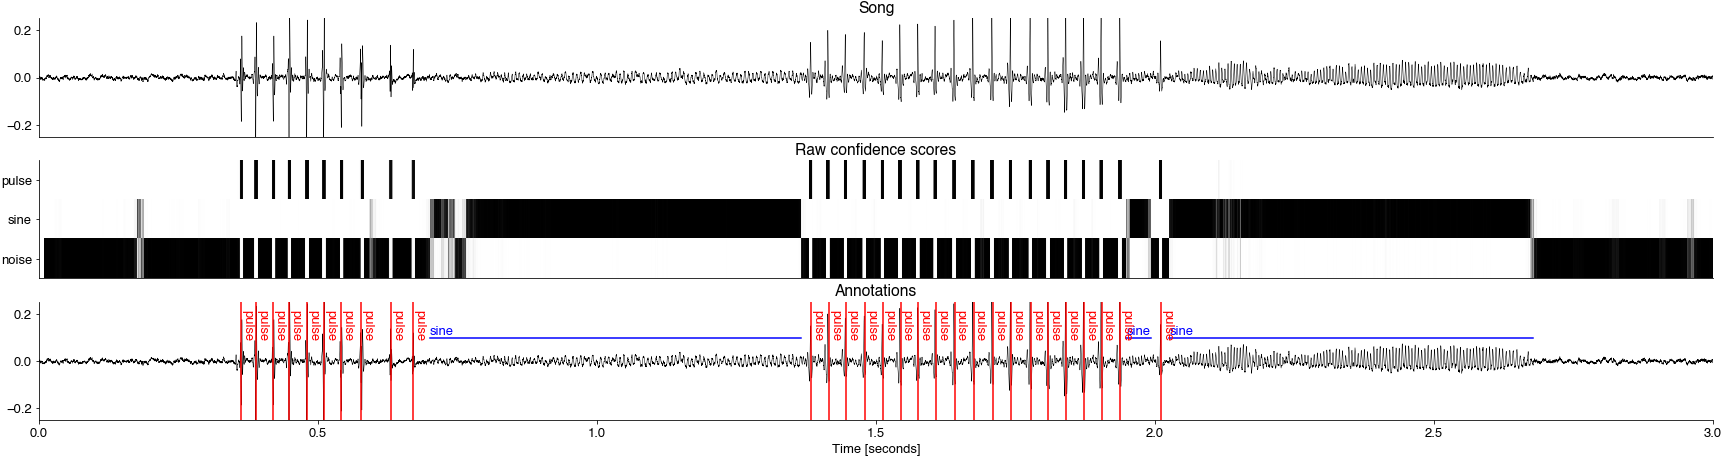

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ncb.mplstyle')

t0 = 0
t1 = 30_000 
fs =segments['samplerate_Hz']
time = np.arange(t0, t1) / fs
nb_classes = class_probabilities.shape[1]

plt.figure(figsize=(30, 10))
plt.subplot(411)
plt.plot(time, x[t0:t1], 'k', linewidth=0.5)
plt.title('Song')
plt.xticks([])
plt.ylim(-0.25, 0.25)

plt.subplot(412)
plt.imshow(class_probabilities[t0:t1].T, cmap='Greys')
plt.yticks(np.arange(nb_classes), labels=class_names)
plt.title('Raw confidence scores')
plt.xticks([])

ax = plt.subplot(413)
plt.plot(time, x[t0:t1],'k', linewidth=0.5)
plt.ylim(-0.25, 0.25)
plt.title('Annotations')
plt.xlabel('Time [seconds]')
for onset, offset, segment_name in zip(segments['onsets_seconds'], segments['offsets_seconds'], segments['sequence']):
    if onset >= t0 /fs and offset <= t1 / fs:
        plt.plot([onset, offset], [0.1, 0.1], c='b')
        ax.annotate(segment_name, xy=(onset, 0.11), c='b')

for pulse_time, pulse_name in zip(events['seconds'], events['sequence']):
    if pulse_time >= t0 /fs and pulse_time <= t1 / fs:
        plt.axvline(pulse_time, c='r')
        ax.annotate(pulse_name, xy=(pulse_time, 0.1), c='r', rotation=-90)


## Prediction using command-line scripts
Will save the output of `das.predict.predict` to a h5 file ending in `_das.h5` or specified via the `--save-filename` argument.

See [cli](/technical/cli) for a full list of arguments.

In [4]:
!das predict dat/dmel_song_rt.wav models/dmel_single_rt/20200430_201821

INFO:root:Loading model from models/dmel_single_rt/20200430_201821.
2022-07-25 13:02:37.243085: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:root:   Loading data from dat/dmel_song_rt.wav.
INFO:root:   Annotating using model at models/dmel_single_rt/20200430_201821.
2022-07-25 13:02:37.763758: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
20/20 [==============================] - 2s 68ms/step
INFO:root:   found 29 instances of events '['pulse']'.
INFO:root:   found 15 instances of segments '['sine']'.
INFO:root:   Saving results to dat/dmel_song_rt_annotations.csv.
INFO:root:Done.


In [5]:
import h5py
with h5py.File('dat/dmel_song_rt_das.h5', mode='r') as f:
    print(list(f.keys()))

['class_names', 'class_probabilities', 'events', 'segments']
